# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## matplotlib 한글 설정  
* 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원. 

In [3]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

In [4]:
# 데이터 저장소 

base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [5]:
# 시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기. 
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

scb_yearly = pd.read_excel(base_path+"Seungchonbo.xlsx", 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

`'측정일/월'` 특성을 '년-월-일 시'형식으로 변경한다.

In [6]:
# 시간 특성을 지정된 형식으로 변환하는 함수

def time2datetime(df_yearly_dict, feature):
    for year in list(df_yearly_dict.keys()):
        df_yearly_dict[year][feature] = df_yearly_dict[year][feature].apply(lambda x : x.strftime('%Y-%m-%d %H'))
    
    return df_yearly_dict

In [7]:
scb_yearly = time2datetime(scb_yearly, '측정일/월')

**연도별 수질 데이터 통합**

* 2013년부터

In [8]:
def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

In [9]:
scb_yearly_df13 = concat_yearly_df(scb_yearly)

**인덱스 재설정**

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

## 승촌보 유량 데이터 불러오기

In [11]:
# 10분 단위로 측정된 연도별 승촌보 유량 데이터를 불러온다. 
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

scb_flow_yearly = pd.read_excel(base_path+"Seungchonbo_flow.xlsx", 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`시간` 특성을 '년-월-일 시' 형식으로 변경한다. 

In [12]:
scb_flow_yearly = time2datetime(scb_flow_yearly, '시간')

**10분 단위를 1시간 단위로 변경**

시간별 평균값을 활용한다.

In [13]:
scb_flow_yearly_hour = {}

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
for year in list(scb_flow_yearly.keys()):
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간', as_index=False).mean()

In [14]:
# for year in scb_flow_yearly_hour:
#     scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

**연도별 유량 데이터 통합**

- 2013년부터

In [15]:
scb_flow_yearly_hour_df = concat_yearly_df(scb_flow_yearly_hour)

**인덱스 재설정**

In [16]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

## 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.

In [17]:
# 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

**특성 선택**

모델 훈련에 사용하지 않을 특성들은 삭제한다.

In [18]:
to_be_removed = ['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)']

scb_data.drop(to_be_removed, axis=1, inplace=True)

**클로로필-a 특성 정규화**

`'클로로필-a mg/㎥'` 특성을 회귀 모델의 타깃으로 사용할 예정이다.
그런데 클로로필 값이 왼편으로 치우친 형태이다.

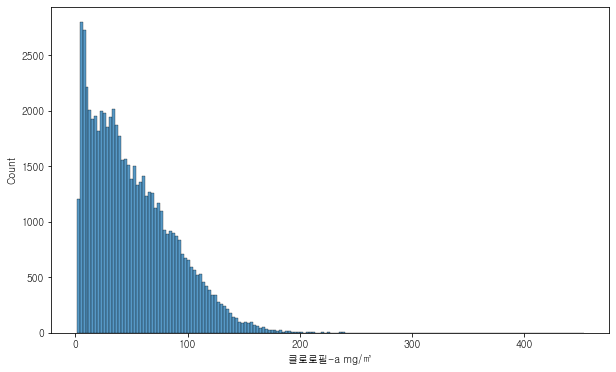

In [19]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포에 가까워진다.

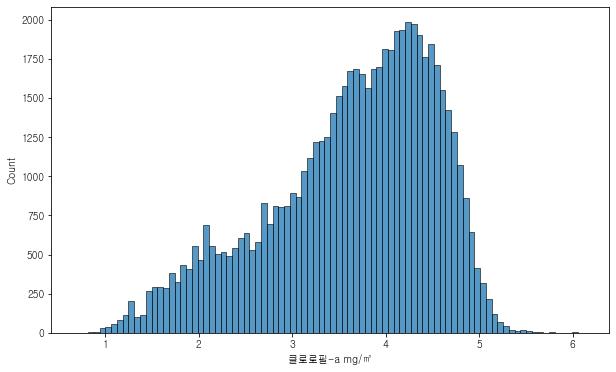

In [20]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환한 뒤 `scb_data`에 추가한 뒤 기존의 클로로필 특성은 고려하지 않는다.

In [21]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

scb_data = scb_data.drop(['클로로필-a mg/㎥'], axis=1)

## shift 특성 추가

데이터셋을 복제해서 원본은 유지한다.

In [22]:
scb_df = scb_data.copy()

**shift 특성 추가 함수** 

`feature_shifting()` 함수는 지정된 특성을 대상으로 지정된 크기만큼 shift한 특성을 추가한다. 함수의 인자로 다음 세 개의 값을 받는다.  

* `df` : 기존 데이터프레임
* `shift_feature` : shift 대상 특성
* `shift_step` : shift 크기

In [23]:
from pandas import DataFrame
import re

def feature_shifting(df : DataFrame, shift_feature : str, shift_step : int) -> DataFrame:
    shift_feature_ = re.split(' |\(', shift_feature)[0] # 특성 이름에 사용된 단위 삭제. 공백 또는 여는 괄호 기준 쪼개기

    new_dict = dict()
    new_dict[str(shift_step) + 'shift_' + shift_feature_] = df[shift_feature].shift(shift_step)
    
    new_dict = pd.DataFrame(new_dict)

    return pd.concat([df, new_dict], axis=1)

In [24]:
# shift 특성과 shift 크기 선택

shift_objects = {'수온 ℃': 2}

**회귀 모델 지정**

In [25]:
reservoir = 'Seungchonbo'

In [26]:
model_kind = 'rf' # random forest

model_reg = RandomForestRegressor(random_state=42, oob_score=True, 
                                # n_jobs=-1
                                n_estimators=500)

In [27]:
# parameters = {'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]} 
# (15, 8) 조합이 좋게 나오기에 다음과 같이 해볼 필요 있음.
# parameters = {'max_depth':[15, 17, 20], 'min_samples_leaf':[6, 7, 8]}

# 아래 경우는 테스트용
parameters = {'max_depth':[17], 'min_samples_leaf':[6]}

## 모델 훈련

In [28]:
def main(model, parameters, shift_feature, shift_step):
    ...

In [34]:
# best models
best_model_dict = dict()

# oob scores of the best models
oob_dict = dict()

# test scores of the best models
test_score_dict = dict()

# train_features of the best models
train_features_dict = dict()

# shift 특성 추가와 모델 훈련
for shift_feature in shift_objects:
    # 지정된 특성을 지정된 크기만큼 shift한 새로운 특성 추가
    shift_step = shift_objects[shift_feature]
    scb_df_shifted = feature_shifting(scb_df, shift_feature, shift_step)

    # 결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.
    scb_df_shifted['시간'] = scb_df_shifted['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))
    scb_df_shifted = scb_df_shifted.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')
    scb_df_shifted.dropna(inplace=True)

    # 타깃 특성
    target_feature = 'log_Chl-a'

    # 입력 특성
    train_features = list(scb_df_shifted.columns)
    train_features.remove(target_feature)

    # 훈련셋과 테스트셋
    inputs = scb_df_shifted[train_features]
    targets = scb_df_shifted[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

    # 모델 훈련: 그리드 탐색 적용
    model_name = f"{reservoir}_{model_kind}_{shift_step}shift_{shift_feature_}"
    print(f"=== Current model: {model_name} ===")

    model_grid = GridSearchCV(model_reg, param_grid=parameters, cv=3, 
                            # n_jobs=-1, 
                            verbose=5)

    model_grid.fit(X_train, y_train)

    # 그리드 탐색 후 최고 성능 모델 저장
    estimator = model_grid.best_estimator_

    shift_feature_ = re.split(' |\(', shift_feature)[0]
    best_model = model_name+".pkl"

    joblib.dump(estimator, best_model)

    # 저장된 모델 다시 불러오기
    estimator = joblib.load(best_model)

    # 최고 성능 및 모델 성능 리스트 추가
    best_model_dict[model_name] = estimator
    oob_dict[model_name] = estimator.oob_score_
    test_score_dict[model_name] = estimator.score(X_test, y_test)
    train_features_dict[model_name] = train_features

=== Current model: Seungchonbo_rf_2shift_수온 ===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..max_depth=17, min_samples_leaf=6;, score=0.903 total time=  38.9s
[CV 2/3] END ..max_depth=17, min_samples_leaf=6;, score=0.905 total time=  38.5s
[CV 3/3] END ..max_depth=17, min_samples_leaf=6;, score=0.904 total time=  38.2s


**특성 중요도**

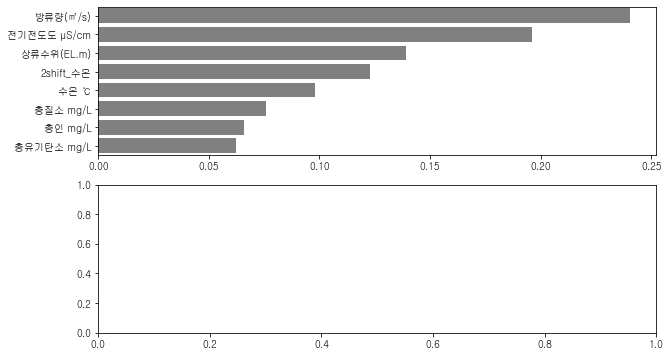

In [56]:
plt.figure(figsize=(10, 6))

models_trained = list(best_model_dict.keys())
num_of_models = len(models_trained)

for idx in range(num_of_models):
    plt.subplot(num_of_models, 1, idx)

    model_ = models_trained[idx]
    estimator_ = best_model_dict[model_]
    train_features_ = train_features_dict[model_]

    feature_series = pd.Series(data = estimator_.feature_importances_, index = train_features_)
    feature_series = feature_series.sort_values(ascending = False)
    sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')

plt.show()

## 모델 훈련 - GradientBoosting

In [73]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [74]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [75]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.741 total time=  33.7s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.742 total time=  33.7s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.744 total time=  33.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.928 total time= 1.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time= 1.1min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.926 total time= 1.1min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.938 total time= 1.6min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.942 total time= 1.6min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.938 total time= 1.6min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.791 total time=  33.9s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.793 total time=  33.8s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [76]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [77]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.942837,1
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.940677,2
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.939444,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.939113,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937523,5


In [78]:
gb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 10}

In [79]:
estimator = gb_grid.best_estimator_

**최신 모델 저장**

In [80]:
import joblib

In [81]:
joblib.dump(estimator, "승촌보_gb_수온.pkl")

['승촌보_gb_수온.pkl']

저장된 모델을 다시 불러오기

In [82]:
estimator = joblib.load("승촌보_gb_수온.pkl")

In [83]:
pred = estimator.predict(X_test)

In [84]:
for score, name in zip(estimator.feature_importances_, col):
    print(round(score, 2), name)

0.06 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.08 2shift 수온
0.02 4shift 수온
0.0 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.01 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.0 24shift 수온
0.01 26shift 수온
0.0 28shift 수온
0.0 30shift 수온
0.0 32shift 수온
0.0 34shift 수온
0.0 36shift 수온
0.0 38shift 수온
0.01 40shift 수온
0.0 42shift 수온
0.0 44shift 수온
0.0 46shift 수온
0.0 48shift 수온
0.0 50shift 수온
0.0 52shift 수온
0.0 54shift 수온
0.0 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.01 66shift 수온
0.01 68shift 수온
0.0 70shift 수온
0.02 72shift 수온


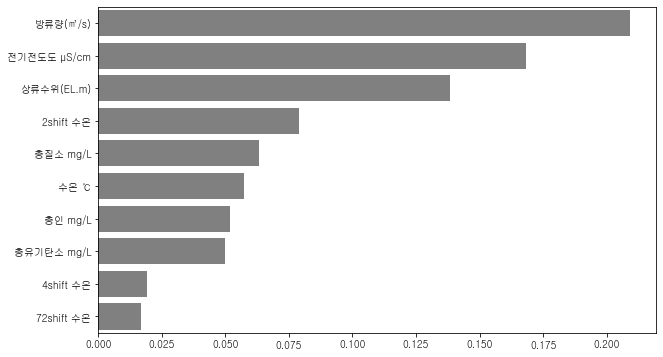

In [85]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [86]:
feature_series[:10]

방류량(㎥/s)       0.208991
전기전도도 μS/cm    0.168133
상류수위(EL.m)     0.138403
2shift 수온      0.078975
총질소 mg/L       0.063097
수온 ℃           0.057175
총인 mg/L        0.051925
총유기탄소 mg/L     0.049896
4shift 수온      0.019267
72shift 수온     0.016908
dtype: float64

In [87]:
print('score :', estimator.score(X_test, y_test))

score : 0.9570012244066335


## shift수온 + 방류량 데이터만

In [88]:
col_v = ['방류량(㎥/s)']

for i in col:
    if '수온' in i:
        col_v.append(i)

In [89]:
print(col_v)

['방류량(㎥/s)', '수온 ℃', '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온', '24shift 수온', '26shift 수온', '28shift 수온', '30shift 수온', '32shift 수온', '34shift 수온', '36shift 수온', '38shift 수온', '40shift 수온', '42shift 수온', '44shift 수온', '46shift 수온', '48shift 수온', '50shift 수온', '52shift 수온', '54shift 수온', '56shift 수온', '58shift 수온', '60shift 수온', '62shift 수온', '64shift 수온', '66shift 수온', '68shift 수온', '70shift 수온', '72shift 수온']


## 모델 훈련 - RandomForest(shift수온 + 방류량)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [91]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, verbose=5)
# rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [92]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [93]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [94]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.696213,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.693913,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.674208,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.671974,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.655448,5


In [95]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [96]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [97]:
joblib.dump(estimator, "승촌보_rf_only수온_방류량.pkl")


['승촌보_rf_only수온_방류량.pkl']

저장된 모델 다시 불러오기

In [98]:
estimator = joblib.load("승촌보_rf_only수온_방류량.pkl")

In [99]:
estimator.oob_score_

0.7306566371546388

In [100]:
pred = estimator.predict(X_test)

In [101]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.42 방류량(㎥/s)
0.1 수온 ℃
0.07 2shift 수온
0.03 4shift 수온
0.02 6shift 수온
0.01 8shift 수온
0.01 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.01 16shift 수온
0.01 18shift 수온
0.01 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.01 26shift 수온
0.01 28shift 수온
0.01 30shift 수온
0.01 32shift 수온
0.01 34shift 수온
0.01 36shift 수온
0.01 38shift 수온
0.01 40shift 수온
0.01 42shift 수온
0.01 44shift 수온
0.01 46shift 수온
0.01 48shift 수온
0.01 50shift 수온
0.01 52shift 수온
0.01 54shift 수온
0.01 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.01 66shift 수온
0.01 68shift 수온
0.01 70shift 수온
0.03 72shift 수온


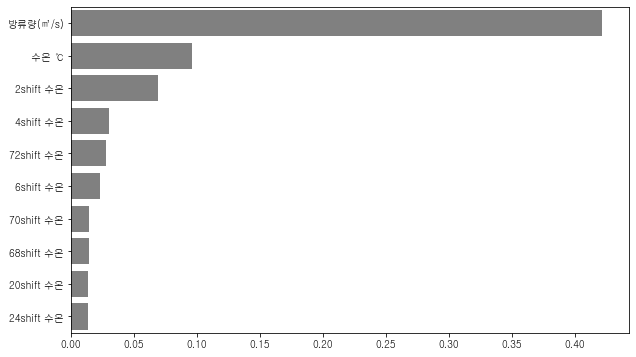

In [102]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [103]:
feature_series[:10]

방류량(㎥/s)      0.421647
수온 ℃          0.095918
2shift 수온     0.069155
4shift 수온     0.030120
72shift 수온    0.027846
6shift 수온     0.022897
70shift 수온    0.014053
68shift 수온    0.013945
20shift 수온    0.013910
24shift 수온    0.013634
dtype: float64

In [104]:
print('score :', estimator.score(X_test, y_test))

score : 0.7301860411749305


## 모델 훈련 - GradientBoosting(shift수온+방류량)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [106]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [107]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.526 total time=  28.5s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.515 total time=  28.6s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.518 total time=  28.7s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.718 total time=  56.4s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.706 total time=  56.8s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.713 total time=  56.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.790 total time= 1.4min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.776 total time= 1.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.768 total time= 1.4min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.560 total time=  28.5s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.551 total time=  28.4s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [108]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [109]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.783220,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.777931,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.777579,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.760120,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.738248,5


In [110]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [111]:
estimator = gb_grid.best_estimator_

최신 모델 저장

In [112]:
joblib.dump(estimator, "승촌보_gb_only수온_방류량.pkl")

['승촌보_gb_only수온_방류량.pkl']

저장된 모델을 다시 불러오기

In [113]:
estimator = joblib.load("승촌보_gb_only수온_방류량.pkl")

In [114]:
pred = estimator.predict(X_test)

In [115]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.36 방류량(㎥/s)
0.1 수온 ℃
0.04 2shift 수온
0.04 4shift 수온
0.02 6shift 수온
0.01 8shift 수온
0.01 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.01 16shift 수온
0.02 18shift 수온
0.02 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.01 26shift 수온
0.01 28shift 수온
0.01 30shift 수온
0.01 32shift 수온
0.01 34shift 수온
0.01 36shift 수온
0.01 38shift 수온
0.01 40shift 수온
0.01 42shift 수온
0.01 44shift 수온
0.01 46shift 수온
0.01 48shift 수온
0.01 50shift 수온
0.01 52shift 수온
0.01 54shift 수온
0.02 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.02 66shift 수온
0.02 68shift 수온
0.02 70shift 수온
0.04 72shift 수온


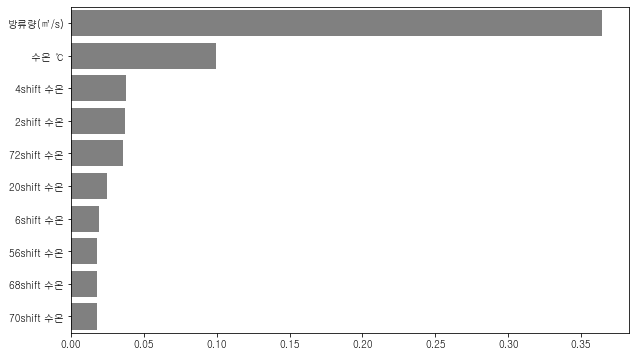

In [116]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [117]:
feature_series[:10]

방류량(㎥/s)      0.364591
수온 ℃          0.099726
4shift 수온     0.038093
2shift 수온     0.037054
72shift 수온    0.035487
20shift 수온    0.024554
6shift 수온     0.019544
56shift 수온    0.018037
68shift 수온    0.017890
70shift 수온    0.017743
dtype: float64

In [118]:
print('score :', estimator.score(X_test, y_test))

score : 0.8306539060515679


## 전체 + 수온대신 2shift수온만

In [119]:
col_2 = ['전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온']
print(col_2)

['전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온']


## 모델 훈련 - RandomForest(전체 + 수온대신 2shift수온)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_2], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [121]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [122]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [123]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [124]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.884662,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.884253,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.867694,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.867318,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.852850,5


In [125]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [126]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [127]:
joblib.dump(estimator, "승촌보_rf_2shift수온.pkl")

['승촌보_rf_2shift수온.pkl']

저장된 모델 다시 불러오기

In [128]:
estimator = joblib.load("승촌보_rf_2shift수온.pkl")

In [129]:
estimator.oob_score_

0.9030601377760745

In [130]:
pred = estimator.predict(X_test)

In [131]:
for score, name in zip(estimator.feature_importances_, col_2):
    print(round(score, 2), name)

0.18 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.15 상류수위(EL.m)
0.23 방류량(㎥/s)
0.22 2shift 수온


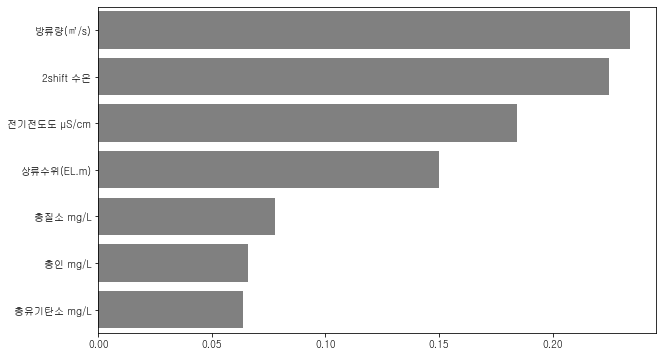

In [132]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_2)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [133]:
feature_series[:10]

방류량(㎥/s)       0.233856
2shift 수온      0.224564
전기전도도 μS/cm    0.184187
상류수위(EL.m)     0.150119
총질소 mg/L       0.077781
총인 mg/L        0.065858
총유기탄소 mg/L     0.063636
dtype: float64

In [134]:
print('score :', estimator.score(X_test, y_test))

score : 0.9008286966361575


## 모델 훈련 - GradientBoosting(전체 + 수온대신 2shift수온)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_2], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [136]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [137]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.730 total time=   7.2s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.728 total time=   7.2s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.726 total time=   7.2s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.902 total time=  14.0s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.901 total time=  14.0s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.904 total time=  14.0s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.925 total time=  20.2s
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.924 total time=  20.2s
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.921 total time=  20.2s
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.771 total time=   7.2s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.767 total time=   7.2s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [138]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [139]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.925326,1
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.923433,2
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.923265,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.921117,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.914253,5


In [140]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [141]:
estimator = gb_grid.best_estimator_

최신 모델 저장

In [142]:
joblib.dump(estimator, "승촌보_gb_2shift수온.pkl")

['승촌보_gb_2shift수온.pkl']

저장된 모델을 다시 불러오기

In [143]:
estimator = joblib.load("승촌보_gb_2shift수온.pkl")

In [144]:
pred = estimator.predict(X_test)

In [145]:
for score, name in zip(estimator.feature_importances_, col_2):
    print(round(score, 2), name)

0.18 전기전도도 μS/cm
0.07 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.15 상류수위(EL.m)
0.22 방류량(㎥/s)
0.22 2shift 수온


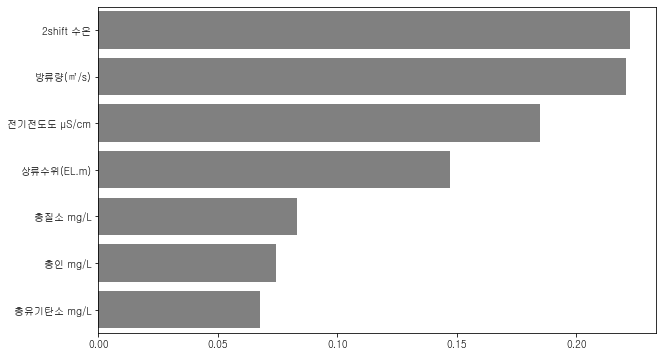

In [146]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_2)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [147]:
feature_series[:10]

2shift 수온      0.222313
방류량(㎥/s)       0.220934
전기전도도 μS/cm    0.184726
상류수위(EL.m)     0.146993
총질소 mg/L       0.083101
총인 mg/L        0.074299
총유기탄소 mg/L     0.067634
dtype: float64

In [148]:
print('score :', estimator.score(X_test, y_test))

score : 0.9447886142140157
